<a href="https://colab.research.google.com/github/SEC-API-io/sec-api-cookbook/blob/main/notebooks/audit-fees/audit-fees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Analysis of Audit Fees Data in SEC DEF 14A Definitive Proxy Statements

This notebook demonstrates an exploratory data analysis examining audit fees reported by public companies filed in SEC Form DEF 14A.

Form DEF 14A (Definitive Proxy Statement) is a filing submitted to the U.S. Securities and Exchange Commission (SEC) by public companies ahead of shareholder meetings. Among other information, the proxy statements include the amount of fees payed to independent auditors.

Leveraging our [Audit Fees API](https://sec-api.io/docs/audit-fees-api), we transform these disclosures into a standardized JSON format, facilitating comprehensive and efficient analysis.

Our analysis addresses several dimensions:

- Temporal trends in the number of Form DEF 14A filings from 2001 to 2025, segmented by quarter, month, and intraday timing (pre-market, regular market hours, after-market).
- Detailed analysis of the distribution and temporal evolution of:
  - Audit Fees
  - Audit-Related Fees
  - Tax Fees
  - All Other Fees Category
- Temporal evolution and comparison of the four fee types


## Quick Start

To quickly retrieve data for a specific company, modify the following example as needed. For more detail, see [Audit Fees API documentation](https://sec-api.io/docs/audit-fees-api) and [sec-api-python package readme](https://github.com/janlukasschroeder/sec-api-python?tab=readme-ov-file#audit-fees).


In [1]:
%pip install -q sec_api # use %pip for reliable install in current environment

In [2]:
# NOTE: Replace with your own API key
API_KEY_SEC_API = "YOUR_API_KEY"

In [3]:
from sec_api import AuditFeesApi
import json

auditFeesApi = AuditFeesApi(api_key=API_KEY_SEC_API)

search_params = {
    "query": "entities.cik:1318605",
    "from": "0",
    "size": "1",
    "sort": [{"filedAt": {"order": "desc"}}],
}

# get proposed sales information, sales history, and other details
response = auditFeesApi.get_data(search_params)
filing = response["data"]

print(json.dumps(filing, indent=2))

{
  "id": "dcfe557d7b36025fb47997b38c2dc46d",
  "accessionNo": "0001193125-16-543341",
  "fileNo": "001-34756",
  "formType": "DEF 14A",
  "filedAt": "2016-04-15T17:09:07-04:00",
  "periodOfReport": "2016-05-31",
  "entities": [
    {
      "cik": "1318605",
      "ticker": "TSLA",
      "companyName": "TESLA MOTORS INC (Filer)",
      "irsNo": "912197729",
      "fiscalYearEnd": "1231",
      "stateOfIncorporation": "DE",
      "sic": "3711 Motor Vehicles &amp; Passenger Car Bodies",
      "act": "34",
      "fileNo": "001-34756",
      "filmNo": "161575120"
    }
  ],
  "records": [
    {
      "year": 2014,
      "auditFees": 2969000,
      "auditRelatedFees": 6000,
      "taxFees": 10000,
      "allOtherFees": 2000,
      "totalFees": 2987000,
      "auditor": "PricewaterhouseCoopers LLP"
    },
    {
      "year": 2015,
      "auditFees": 4237000,
      "auditRelatedFees": 0,
      "taxFees": 0,
      "allOtherFees": 2000,
      "totalFees": 4239000,
      "auditor": "Pricewaterho

In [4]:
import sys
import os
import time
import random

# from multiprocessing import Pool # use in .py files only
from concurrent.futures import ThreadPoolExecutor

YEARS = range(2025, 1999, -1)  # from 2025 to 2018
TEMP_FILE_TEMPLATE = "./temp_file_audit_fees_{}.jsonl"
TARGET_FILE = "./audit-fees-dataset.jsonl.gz"


def process_year(year):
    backoff_time = random.randint(10, 800) / 1000
    print(f"Starting year {year} with backoff time {backoff_time:,}s")
    sys.stdout.flush()
    time.sleep(backoff_time)

    tmp_filename = TEMP_FILE_TEMPLATE.format(year)
    tmp_file = open(tmp_filename, "a")

    for month in range(12, 0, -1):
        search_from = 0
        month_counter = 0

        while True:
            query = f"filedAt:[{year}-{month:02d}-01 TO {year}-{month:02d}-31]"
            searchRequest = {
                "query": query,
                "from": search_from,
                "size": "50",
                "sort": [{"filedAt": {"order": "desc"}}],
            }

            response = None
            try:
                response = auditFeesApi.get_data(searchRequest)
            except Exception as e:
                print(f"{year}-{month:02d} error: {e}")
                sys.stdout.flush()
                continue

            if response == None or len(response["data"]) == 0:
                break

            search_from += 50
            month_counter += len(response["data"])
            jsonl_data = "\n".join([json.dumps(entry) for entry in response["data"]])
            tmp_file.write(jsonl_data + "\n")

        print(f"Finished loading {month_counter} filings for {year}-{month:02d}")
        sys.stdout.flush()

    tmp_file.close()

    return year


if not os.path.exists(TARGET_FILE):
    with ThreadPoolExecutor(max_workers=4) as pool:
        processed_years = list(pool.map(process_year, YEARS))
    print("Finished processing all years.", processed_years)

    import gzip

    # Merge the temporary files into one final compressed file
    with gzip.open(TARGET_FILE, "wt", encoding="utf-8") as outfile:
        for year in YEARS:
            temp_file = TEMP_FILE_TEMPLATE.format(year)
            if os.path.exists(temp_file):
                with open(temp_file, "r", encoding="utf-8") as infile:
                    for line in infile:
                        outfile.write(line)  # Preserve JSONL format
else:
    print("File already exists. Skipping download.")

File already exists. Skipping download.


## Analyzing Data


In [5]:
# install all dependencies required for the notebook
%pip install -q pandas numpy matplotlib seaborn scipy

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as mtick
import seaborn as sns
from scipy.stats import skew, kurtosis

style.use("default")

params = {
    "axes.labelsize": 8,
    "font.size": 8,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "font.family": "sans-serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.color": "grey",
    "axes.grid": True,
    "axes.grid.axis": "y",
    "grid.alpha": 0.5,
    "grid.linestyle": ":",
}

plt.rcParams.update(params)

form_name = "Form DEF 14A"
form_name_escaped = "form-def-14a"

In [7]:
data_file = "../output/audit-fees-dataset-consumer.jsonl"

structured_data = pd.read_json(data_file, lines=True)

structured_data["firstEntityCik"] = structured_data.apply(
    lambda x: x["entities"][0]["cik"], axis=1
)

structured_data["filedAt"] = pd.to_datetime(structured_data["filedAt"], utc=True)
structured_data["filedAt"] = structured_data["filedAt"].dt.tz_convert("US/Eastern")
structured_data = structured_data.sort_values("filedAt", ascending=True).reset_index(
    drop=True
)

structured_data.drop_duplicates("accessionNo", keep="first", inplace=True)
structured_data["filedAtYear"] = structured_data["filedAt"].dt.year
structured_data["filedAtMonth"] = structured_data["filedAt"].dt.month
structured_data["filedAtQtr"] = structured_data["filedAtMonth"].apply(
    lambda x: (x - 1) // 3 + 1
)
structured_data["filedAtDayOfWeek"] = structured_data["filedAt"].dt.day_name()
# filedAtClass: preMarket (4:00AM-9:30AM), regularMarket (9:30AM-4:00PM), afterMarket (4:00PM-8:00PM)
structured_data["filedAtClass"] = structured_data["filedAt"].apply(
    lambda x: (
        "preMarket"
        if x.hour < 9 or (x.hour == 9 and x.minute < 30)
        else (
            "regularMarket"
            if x.hour < 16
            else "afterMarket" if x.hour < 20 else "other"
        )
    )
)
structured_data["periodOfReportYear"] = structured_data["periodOfReport"].apply(
    lambda x: x.split("-")[0] if isinstance(x, str) else np.nan
)
structured_data["periodOfReportMonth"] = structured_data["periodOfReport"].apply(
    lambda x: x.split("-")[1] if isinstance(x, str) else np.nan
)


structured_data = structured_data.explode("records").reset_index(
    drop=True
)  # ← this fixes the issue

normalized_df = pd.json_normalize(structured_data["records"])

structured_data = pd.concat(
    [structured_data.drop(columns=["records"]), normalized_df], axis=1
)
structured_data.head(5)

,id,accessionNo,fileNo,formType,filedAt,periodOfReport,entities,tableId,firstEntityCik,filedAtYear,...,periodOfReportYear,periodOfReportMonth,year,auditFees,auditRelatedFees,taxFees,allOtherFees,totalFees,auditor,valueMultiplier
0,fa41cba0dcce2dc28bbafb8e9c0a02b5,0000912057-01-007088,001-00768,DEF 14A,2001-03-02 00:00:00-05:00,2001-04-11,"[{'cik': '18230', 'ticker': 'CAT', 'companyNam...",0000912057-01-007088_10,18230,2001,...,2001,04,2000.0,6700000.0,NaN,NaN,16200000.0,NaN,,1000000
1,08ea344d14d1393d30248a8d448bca59,0000064463-01-500011,000-06890,DEF 14A,2001-03-07 00:00:00-05:00,2001-04-24,"[{'cik': '64463', 'ticker': 'SLNH', 'companyNa...",0000064463-01-500011_6,64463,2001,...,2001,04,2000.0,95415.0,NaN,NaN,75645.0,171060.0,PricewaterhouseCoopers LLP,1
2,f7cfd8bdda5be061111e63f5090be67e,0000950152-01-500225,000-13270,DEF 14A,2001-03-09 00:00:00-05:00,2001-04-24,"[{'cik': '746481', 'companyName': 'UNB CORP/OH...",0000950152-01-500225_24,746481,2001,...,2001,04,2000.0,67500.0,NaN,NaN,163628.0,NaN,"Crowe, Chizek and Company",1
3,71e870d51d55da9c79c9f2f6fd2bb56a,0000891554-01-501345,001-09026,DEF 14A,2001-03-12 00:00:00-05:00,2001-04-26,"[{'cik': '714154', 'companyName': 'COMPAQ COMP...",0000891554-01-501345_86,714154,2001,...,2001,04,2000.0,5600000.0,3200000.0,7400000.0,NaN,16200000.0,,1
4,dc18b46a1680a1925046a541f83b5ca4,0000950109-01-500193,001-07410,DEF 14A,2001-03-12 00:00:00-05:00,2001-04-17,"[{'cik': '64782', 'companyName': 'MELLON FINAN...",0000950109-01-500193_60,64782,2001,...,2001,04,2000.0,2553000.0,NaN,584000.0,9857000.0,12994000.0,KPMG LLP,1000


In [8]:
unique_years = structured_data["filedAtYear"].nunique()
unique_companies = structured_data["firstEntityCik"].nunique()
unique_filings = structured_data["accessionNo"].nunique()
tickers = structured_data["entities"].apply(
    lambda x: (
        x[0]["ticker"]
        if len(x) > 0 and isinstance(x[0], dict) and "ticker" in x[0]
        else None
    )
)
unique_tickers = tickers.nunique()
min_year = structured_data["filedAtYear"].min()
max_year = structured_data["filedAtYear"].max()
print(f"Loaded dataframe with main documents of {form_name} filings")
print(f"Number of filings: {unique_filings:,}")
print(f"Number of records: {len(structured_data):,}")
print(f"Number of years: {unique_years:,} ({min_year}-{max_year})")
# print(f"Number of unique companies: {unique_companies:,}")
print(f"Number of unique issuers: {unique_companies:,}")
print(f"Number of unique ticker symbols found: {unique_tickers:,}")

Loaded dataframe with main documents of Form DEF 14A filings
Number of filings: 69,229
Number of records: 139,251
Number of years: 25 (2001-2025)
Number of unique issuers: 10,057
Number of unique ticker symbols found: 4,655


In [9]:
structured_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139251 entries, 0 to 139250
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype                     
---  ------               --------------   -----                     
 0   id                   139251 non-null  object                    
 1   accessionNo          139251 non-null  object                    
 2   fileNo               139193 non-null  object                    
 3   formType             139251 non-null  object                    
 4   filedAt              139251 non-null  datetime64[ns, US/Eastern]
 5   periodOfReport       136544 non-null  object                    
 6   entities             139251 non-null  object                    
 7   tableId              139251 non-null  object                    
 8   firstEntityCik       139251 non-null  object                    
 9   filedAtYear          139251 non-null  int32                     
 10  filedAtMonth         139251 non-null  int32 

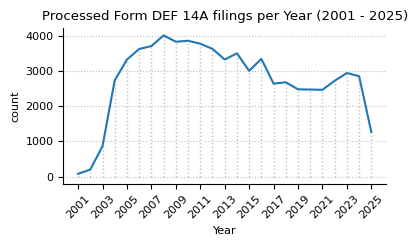

In [10]:
def plot_timeseries(
    ts,
    title,
    keys=["count"],
    y_label=None,
    ylog_scale=False,
    yvalue_multiplier=1,
    yvalue_multiplier_name=None,
    ax=None,
    yticks_step=2,
):
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 2.5))
    else:
        fig = ax.figure

    # Auto y-label with unit
    if y_label is None:
        y_label = keys[0] if len(keys) == 1 else "Value"
    if yvalue_multiplier == "auto":
        yvalue_multiplier = 1
        max_value = ts[keys].max().max()
        if max_value > 1_000_000_000_000:
            yvalue_multiplier = 1_000_000_000_000
        elif max_value > 1_000_000_000:
            yvalue_multiplier = 1_000_000_000
        elif max_value > 1_000_000:
            yvalue_multiplier = 1_000_000
        elif max_value > 1_000:
            yvalue_multiplier = 1_000

    if yvalue_multiplier != 1:
        if yvalue_multiplier_name is not None:
            y_label = f"{y_label} ({yvalue_multiplier_name})"
        elif yvalue_multiplier == 1_000:
            y_label += " (Thousands)"
        elif yvalue_multiplier == 1_000_000:
            y_label += " (Millions)"
        elif yvalue_multiplier == 1_000_000_000:
            y_label += " (Billions)"
        elif yvalue_multiplier == 1_000_000_000_000:
            y_label += " (Trillions)"
        else:
            y_label += f" (÷{yvalue_multiplier:,})"

    # Apply multiplier
    ts_plot = ts.copy()
    ts_plot[keys] = ts_plot[keys] / yvalue_multiplier

    # Plot each key
    for key in keys:
        ts_plot[key].plot(ax=ax, label=key.capitalize())

    if ylog_scale:
        ax.set_yscale("log")

    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel(y_label)
    ax.set_xticks(np.arange(min_year, max_year + 1, yticks_step))
    ax.grid(axis="x")
    ax.set_axisbelow(True)
    # ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

    # Add vertical lines at each year, height = max across all keys
    max_vals = ts_plot[keys].max(axis=1)
    for year in ts_plot.index:
        val = max_vals.get(year, 0)
        if not pd.isna(val):
            ax.vlines(year, 0, val, linestyles=":", colors="grey", alpha=0.5, lw=1)

    for label in ax.get_xticklabels():
        label.set_rotation(45)
    if len(keys) > 1:
        ax.legend()

    plt.tight_layout()
    return fig, ax


filing_counts = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["filedAtYear"])
    .size()
    .to_frame(name="count")
)

fig, ax = plot_timeseries(
    filing_counts,
    title=f"Processed {form_name} filings per Year ({min_year} - {max_year})",
)

In [11]:
form_counts_by_type_and_year = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["filedAtYear", "formType"])
    .size()
    .to_frame(name="count")
    .unstack(fill_value=0)
)


print(f"{form_name} counts from {min_year} to {max_year}.")
form_counts_by_type_and_year

Form DEF 14A counts from 2001 to 2025.


,count
formType,DEF 14A
filedAtYear,
2001,79
2002,200
2003,863
2004,2729
2005,3320
2006,3619
2007,3702
2008,4005


In [12]:
counts_qtr_yr_piv = (
    structured_data.groupby(["filedAtYear", "filedAtQtr"]).size().unstack().fillna(0)
).astype(int)

print(f"{form_name} counts by quarter from {min_year} to {max_year}.")
counts_qtr_yr_piv.T

Form DEF 14A counts by quarter from 2001 to 2025.


filedAtYear,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
filedAtQtr,,,,,,,,,,,,,,,,,,,,,
1,15,48,358,1676,1860,2196,1782,2162,2200,2333,...,2046,1951,1485,1444,1209,1235,1255,1363,1259,1340
2,39,104,735,2795,3474,3695,4147,4443,4060,3966,...,3607,2531,2927,2748,2890,2829,3227,3391,3434,1196
3,16,26,183,585,715,734,777,753,720,741,...,521,419,537,400,444,420,501,547,481,0
4,9,35,253,512,694,745,822,752,781,757,...,555,406,427,385,414,438,478,593,553,0


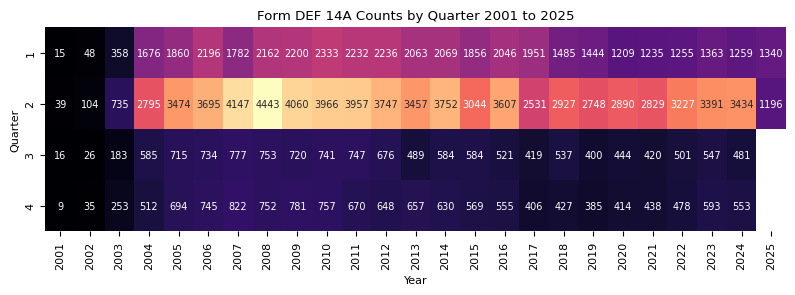

In [13]:
plt.figure(figsize=(8, 3))

sns.heatmap(
    counts_qtr_yr_piv.T,
    annot=True,  # Display the cell values
    fmt="d",  # Integer formatting
    cmap="magma",  # Color map
    cbar_kws={"label": "Count"},  # Colorbar label
    mask=counts_qtr_yr_piv.T == 0,  # Mask the cells with value 0
    cbar=False,
    annot_kws={"fontsize": 7},
)
plt.grid(False)
plt.title(f"{form_name} Counts by Quarter {min_year} to {max_year}")
plt.xlabel("Year")
plt.ylabel("Quarter")
plt.tight_layout()
plt.show()

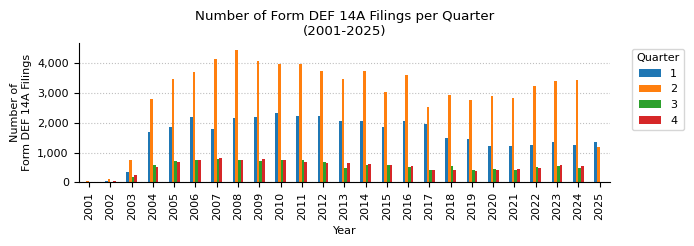

In [14]:
counts_qtr_yr = counts_qtr_yr_piv.stack().reset_index(name="count")

fig, ax = plt.subplots(figsize=(7, 2.5))
counts_qtr_yr_piv.plot(kind="bar", ax=ax, legend=True)
ax.legend(title="Quarter", loc="upper right", bbox_to_anchor=(1.15, 1))
ax.set_title(f"Number of {form_name} Filings per Quarter\n({min_year}-{max_year})")
ax.set_xlabel("Year")
ax.set_ylabel(f"Number of\n{form_name} Filings")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x")
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

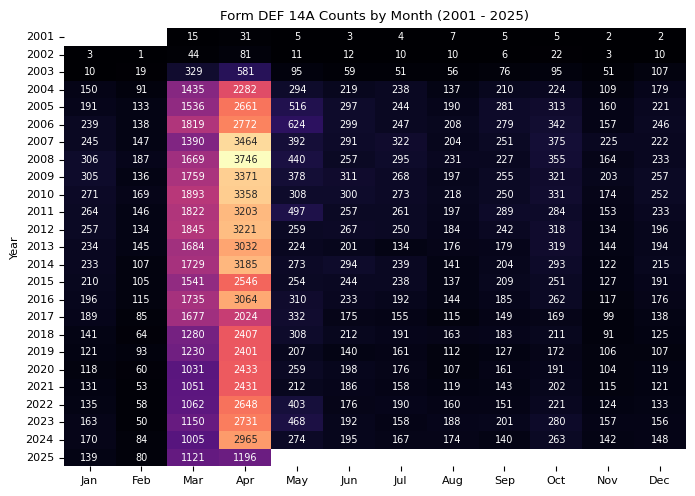

In [15]:
counts_month_yr_piv = (
    structured_data.groupby(["filedAtYear", "filedAtMonth"]).size().unstack().fillna(0)
).astype(int)

plt.figure(figsize=(7, 5))
sns.heatmap(
    counts_month_yr_piv,
    annot=True,
    fmt="d",
    cmap="magma",
    cbar_kws={"label": "Count"},
    mask=counts_month_yr_piv == 0,
    cbar=False,
    annot_kws={"size": 7},
)
# convert x-labels to month names: 1 => Jan, 2 => Feb, etc.
plt.xticks(
    ticks=np.arange(0.5, 12.5, 1),
    labels=[pd.to_datetime(str(i), format="%m").strftime("%b") for i in range(1, 13)],
)
plt.grid(False)
plt.title(f"{form_name} Counts by Month ({min_year} - {max_year})")
plt.xlabel("")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

In [16]:
print(
    f"Descriptive statistics for {form_name} filing counts by month from {min_year} to {max_year}."
)
month_stats = (
    counts_month_yr_piv.loc[2004:]
    .describe(percentiles=[0.025, 0.975])
    .round(0)
    .astype(int)
)
month_stats

Descriptive statistics for Form DEF 14A filing counts by month from 2001 to 2025.


filedAtMonth,1,2,3,4,5,6,7,8,9,10,11,12
count,22,22,22,22,22,22,22,22,22,22,22,22
mean,200,108,1476,2779,329,225,207,159,196,259,133,176
std,60,40,309,567,132,71,69,51,66,84,45,62
min,118,50,1005,1196,0,0,0,0,0,0,0,0
2.5%,120,52,1019,1631,109,74,70,56,67,89,48,56
50%,194,106,1538,2752,308,226,215,168,202,272,130,185
97.5%,305,178,1868,3598,567,305,308,224,285,364,213,254
max,306,187,1893,3746,624,311,322,231,289,375,225,257


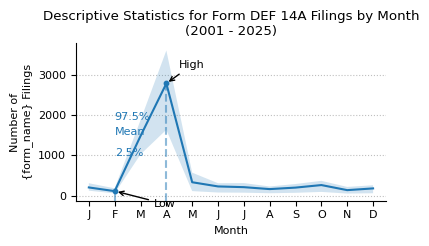

In [17]:
def plot_box_plot_as_line(
    data: pd.DataFrame,
    x_months=True,
    title="",
    x_label="",
    x_pos_mean_label=2,
    pos_labels=None,
    pos_high_low=None,
    y_label="",
    y_formatter=lambda x, p: "{:.0f}".format(int(x) / 1000),
    show_high_low_labels=True,
    show_inline_labels=True,
    show_bands=True,
    figsize=(4, 2.5),
    line_source="mean",
):
    fig, ax = plt.subplots(figsize=figsize)

    line_to_plot = data[line_source]
    lower_label = "2.5%"
    upper_label = "97.5%"
    lower = data[lower_label]
    upper = data[upper_label]

    line_to_plot.plot(ax=ax)

    if show_bands:
        ax.fill_between(line_to_plot.index, lower, upper, alpha=0.2)

    if x_months:
        ax.set_xlim(0.5, 12.5)
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

    ax.yaxis.set_major_formatter(mtick.FuncFormatter(y_formatter))
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)

    ymin, ymax = ax.get_ylim()
    y_scale = ymax - ymin

    max_x = int(line_to_plot.idxmax())
    max_y = line_to_plot.max()
    min_x = int(line_to_plot.idxmin())
    min_y = line_to_plot.min()

    ax.axvline(
        max_x,
        ymin=0,
        ymax=((max_y - ymin) / (ymax - ymin)),
        linestyle="dashed",
        color="tab:blue",
        alpha=0.5,
    )
    ax.scatter(max_x, max_y, color="tab:blue", s=10)
    ax.axvline(
        min_x,
        ymin=0,
        ymax=((min_y - ymin) / (ymax - ymin)),
        linestyle="dashed",
        color="tab:blue",
        alpha=0.5,
    )
    ax.scatter(min_x, min_y, color="tab:blue", s=10)

    x_pos_mean_label_int = int(x_pos_mean_label)
    if show_inline_labels:
        mean_x = x_pos_mean_label
        mean_y = line_to_plot.iloc[x_pos_mean_label_int] * 1.02
        upper_x = x_pos_mean_label
        upper_y = upper.iloc[x_pos_mean_label_int]
        lower_x = x_pos_mean_label
        lower_y = lower.iloc[x_pos_mean_label_int] * 0.95

        if pos_labels:
            mean_x = pos_labels["mean"]["x"]
            mean_y = pos_labels["mean"]["y"]
            upper_x = pos_labels["upper"]["x"]
            upper_y = pos_labels["upper"]["y"]
            lower_x = pos_labels["lower"]["x"]
            lower_y = pos_labels["lower"]["y"]

        ax.text(mean_x, mean_y, "Mean", color="tab:blue", fontsize=8)
        ax.text(upper_x, upper_y, upper_label, color="tab:blue", fontsize=8)
        ax.text(lower_x, lower_y, lower_label, color="tab:blue", fontsize=8)

    if show_high_low_labels:
        high_x_origin = max_x
        high_y_origin = max_y
        high_x_label = high_x_origin + 0.5
        high_y_label = high_y_origin + 0.1 * y_scale
        if pos_high_low:
            high_x_label = pos_high_low["high"]["x"]
            high_y_label = pos_high_low["high"]["y"]
        ax.annotate(
            "High",
            (high_x_origin, high_y_origin),
            xytext=(high_x_label, high_y_label),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
        )

        low_x_origin = min_x * 1.01
        low_y_origin = min_y
        low_x_label = low_x_origin + 1.5
        low_y_label = low_y_origin - 0.1 * y_scale
        if pos_high_low:
            low_x_label = pos_high_low["low"]["x"]
            low_y_label = pos_high_low["low"]["y"]
        ax.annotate(
            "Low",
            (low_x_origin, low_y_origin),
            xytext=(low_x_label, low_y_label),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
        )

    ax.grid(axis="x")
    ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()


plot_box_plot_as_line(
    data=month_stats.T,
    title=f"Descriptive Statistics for {form_name} Filings by Month\n({min_year} - {max_year})",
    x_label="Month",
    y_label="Number of\n{form_name} Filings",
    y_formatter=lambda x, p: "{:.0f}".format(int(x)),
    x_pos_mean_label=2,
)

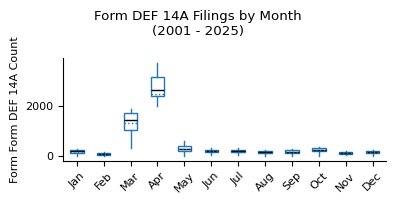

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))

cnt = 0

data = (
    structured_data.groupby(["filedAtYear", "filedAtMonth"])
    .size()
    .unstack()
    .fillna(0)
    .reindex(columns=range(1, 13), fill_value=0)  # ensure all month are included
)

# if data.sum().sum() < 100:
#     continue
try:
    data.boxplot(
        ax=ax,
        grid=False,
        showfliers=False,
        flierprops=dict(marker="o", markersize=3),
        patch_artist=True,
        boxprops=dict(facecolor="white", color="tab:blue"),
        showmeans=True,
        meanline=True,
        meanprops={"color": "tab:blue", "linestyle": ":"},
        medianprops={"color": "black"},
        capprops={"color": "none"},
    )

    ax.set_xlabel("")
    ax.set_ylabel(f"Form {form_name} Count")
    xticklabels = [
        pd.to_datetime(str(x), format="%m").strftime("%b") for x in range(1, 13)
    ]
    ax.set_xticklabels(xticklabels)
    ax.tick_params(axis="x", rotation=45)
except Exception as e:
    print(f"Error: {e}")


fig.suptitle(f"{form_name} Filings by Month\n({min_year} - {max_year})")
plt.tight_layout()
plt.show()

In [19]:
counts_dayOfWeek = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["filedAtDayOfWeek"])
    .size()
    .to_frame(name="Count")
).rename_axis("Day of the Week")
counts_dayOfWeek["Pct"] = (
    counts_dayOfWeek["Count"].astype(int) / counts_dayOfWeek["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_dayOfWeek["Count"] = counts_dayOfWeek["Count"].map(lambda x: f"{x:,}")

print(f"{form_name} filing counts by day of the week ({min_year} - {max_year}).")
counts_dayOfWeek.loc[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]]

Form DEF 14A filing counts by day of the week (2001 - 2025).


,Count,Pct
Day of the Week,,
Monday,"13,280",19%
Tuesday,"11,061",16%
Wednesday,"11,641",17%
Thursday,"13,356",19%
Friday,"19,890",29%


## Deduplicate Records

Audit fee tables in Form DEF 14A filings typically include values for multiple years.
These are typically presented in one column per year.

Because we extract all data from each of the audit fee tables the same data likely appears twice.

To illustrate this, let's list the audit fee records from TESLA DEF 14A filings for the years 2015 to 2018.


In [20]:
structured_data[
    (structured_data["firstEntityCik"] == "1318605")
    & (structured_data["filedAtYear"].isin(range(2016, 2020)))
]

,id,accessionNo,fileNo,formType,filedAt,periodOfReport,entities,tableId,firstEntityCik,filedAtYear,...,periodOfReportYear,periodOfReportMonth,year,auditFees,auditRelatedFees,taxFees,allOtherFees,totalFees,auditor,valueMultiplier
90925,dcfe557d7b36025fb47997b38c2dc46d,0001193125-16-543341,001-34756,DEF 14A,2016-04-15 17:09:07-04:00,2016-05-31,"[{'cik': '1318605', 'ticker': 'TSLA', 'company...",0001193125-16-543341_84,1318605,2016,...,2016,05,2014.0,2969000.0,6000.0,10000.0,2000.0,2987000.0,PricewaterhouseCoopers LLP,1000
90926,dcfe557d7b36025fb47997b38c2dc46d,0001193125-16-543341,001-34756,DEF 14A,2016-04-15 17:09:07-04:00,2016-05-31,"[{'cik': '1318605', 'ticker': 'TSLA', 'company...",0001193125-16-543341_84,1318605,2016,...,2016,05,2015.0,4237000.0,0.0,0.0,2000.0,4239000.0,PricewaterhouseCoopers LLP,1000
102657,ef8759b2cbf14f10e14349ed18353bd7,0001564590-18-009339,001-34756,DEF 14A,2018-04-26 17:00:09-04:00,2018-06-05,"[{'cik': '1318605', 'ticker': 'TSLA', 'company...",0001564590-18-009339_74,1318605,2018,...,2018,06,2016.0,8436000.0,0.0,31000.0,2000.0,8469000.0,PricewaterhouseCoopers LLP,1000
102658,ef8759b2cbf14f10e14349ed18353bd7,0001564590-18-009339,001-34756,DEF 14A,2018-04-26 17:00:09-04:00,2018-06-05,"[{'cik': '1318605', 'ticker': 'TSLA', 'company...",0001564590-18-009339_74,1318605,2018,...,2018,06,2017.0,10613000.0,240000.0,64000.0,2000.0,10919000.0,PricewaterhouseCoopers LLP,1000
108446,0ff2241331a95eba0ac6d12597b19c48,0001564590-19-014268,001-34756,DEF 14A,2019-04-30 16:05:27-04:00,2019-06-11,"[{'cik': '1318605', 'ticker': 'TSLA', 'company...",0001564590-19-014268_125,1318605,2019,...,2019,06,2017.0,10613000.0,240000.0,64000.0,2000.0,10919000.0,PricewaterhouseCoopers LLP,1000
108447,0ff2241331a95eba0ac6d12597b19c48,0001564590-19-014268,001-34756,DEF 14A,2019-04-30 16:05:27-04:00,2019-06-11,"[{'cik': '1318605', 'ticker': 'TSLA', 'company...",0001564590-19-014268_125,1318605,2019,...,2019,06,2018.0,12088000.0,160000.0,514000.0,3000.0,12766000.0,PricewaterhouseCoopers LLP,1000


Indeed, there multiple rows contain the same extracted data, e.g. for 2017, from DEF 14As filed in consecutive years.

Next, lets deduplicate the records and only keep the records for a given year coming from the most recent filings.
We use the fileNo value assigned by the SEC to identify companies, in this case '001-34756' for TESLA.


Now, let's apply this to the full dataset to only keep the most recent set of records reported per company for each year.


In [21]:
structured_data["rank"] = structured_data.groupby(["year", "firstEntityCik"])[
    "filedAt"
].rank(method="dense", ascending=False)

# Keep only the most recent records (rank 1)
structured_data = (
    structured_data[structured_data["rank"] == 1]
    .drop(columns="rank")
    .reset_index(drop=True)
)
structured_data.info()
structured_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83520 entries, 0 to 83519
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype                     
---  ------               --------------  -----                     
 0   id                   83520 non-null  object                    
 1   accessionNo          83520 non-null  object                    
 2   fileNo               83462 non-null  object                    
 3   formType             83520 non-null  object                    
 4   filedAt              83520 non-null  datetime64[ns, US/Eastern]
 5   periodOfReport       81996 non-null  object                    
 6   entities             83520 non-null  object                    
 7   tableId              83520 non-null  object                    
 8   firstEntityCik       83520 non-null  object                    
 9   filedAtYear          83520 non-null  int32                     
 10  filedAtMonth         83520 non-null  int32                

,id,accessionNo,fileNo,formType,filedAt,periodOfReport,entities,tableId,firstEntityCik,filedAtYear,...,periodOfReportYear,periodOfReportMonth,year,auditFees,auditRelatedFees,taxFees,allOtherFees,totalFees,auditor,valueMultiplier
0,fa41cba0dcce2dc28bbafb8e9c0a02b5,0000912057-01-007088,001-00768,DEF 14A,2001-03-02 00:00:00-05:00,2001-04-11,"[{'cik': '18230', 'ticker': 'CAT', 'companyNam...",0000912057-01-007088_10,18230,2001,...,2001,04,2000.0,6700000.0,NaN,NaN,16200000.0,NaN,,1000000
1,08ea344d14d1393d30248a8d448bca59,0000064463-01-500011,000-06890,DEF 14A,2001-03-07 00:00:00-05:00,2001-04-24,"[{'cik': '64463', 'ticker': 'SLNH', 'companyNa...",0000064463-01-500011_6,64463,2001,...,2001,04,2000.0,95415.0,NaN,NaN,75645.0,171060.0,PricewaterhouseCoopers LLP,1
2,f7cfd8bdda5be061111e63f5090be67e,0000950152-01-500225,000-13270,DEF 14A,2001-03-09 00:00:00-05:00,2001-04-24,"[{'cik': '746481', 'companyName': 'UNB CORP/OH...",0000950152-01-500225_24,746481,2001,...,2001,04,2000.0,67500.0,NaN,NaN,163628.0,NaN,"Crowe, Chizek and Company",1
3,71e870d51d55da9c79c9f2f6fd2bb56a,0000891554-01-501345,001-09026,DEF 14A,2001-03-12 00:00:00-05:00,2001-04-26,"[{'cik': '714154', 'companyName': 'COMPAQ COMP...",0000891554-01-501345_86,714154,2001,...,2001,04,2000.0,5600000.0,3200000.0,7400000.0,NaN,16200000.0,,1
4,dc18b46a1680a1925046a541f83b5ca4,0000950109-01-500193,001-07410,DEF 14A,2001-03-12 00:00:00-05:00,2001-04-17,"[{'cik': '64782', 'companyName': 'MELLON FINAN...",0000950109-01-500193_60,64782,2001,...,2001,04,2000.0,2553000.0,NaN,584000.0,9857000.0,12994000.0,KPMG LLP,1000


## Outlier Removal


In [22]:
analysis_df = structured_data.copy()
analysis_df = analysis_df[analysis_df["year"].between(2002, 2026)]

# Calculate percentiles per year
percentiles = analysis_df.groupby("year")["auditFees"].transform

analysis_df["audit_fees_5th"] = percentiles(lambda x: x.quantile(0.05))
analysis_df["audit_fees_95th"] = percentiles(lambda x: x.quantile(0.95))
print(f"5th percentile (min): {analysis_df['audit_fees_5th'].min()}")
print(f"95th percentile (max): {analysis_df['audit_fees_95th'].max()}")

# Filter rows within 5th and 95th percentile for their year
analysis_df = analysis_df[
    (analysis_df["auditFees"] >= analysis_df["audit_fees_5th"])
    & (analysis_df["auditFees"] <= analysis_df["audit_fees_95th"])
]

# Optional: drop temporary columns if no longer needed
analysis_df.drop(columns=["audit_fees_5th", "audit_fees_95th"], inplace=True)

5th percentile (min): 34470.0
95th percentile (max): 13011255.399999999


/var/folders/83/7b5245js685cr2ybfzjf9yq00000gn/T/ipykernel_56145/1805469249.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df.drop(columns=["audit_fees_5th", "audit_fees_95th"], inplace=True)


## Audit Fees


In [23]:
def plot_hist(
    data,
    title=None,
    x_label=None,
    y_label=None,
    log_scale=False,
    xlog_scale=False,
    ylog_scale=False,
    bins=None,
    xticks=None,
    use_xticks_formatter=False,
    use_yticks_formatter=False,
    value_multiplier=1,
    value_range=None,
    ax=None,
    integer_bins=False,
    show_bound_lines=False,
):
    if log_scale:
        xlog_scale = True
        ylog_scale = True

    data = np.array(data)

    # Filter
    if value_range is not None:
        min_val, max_val = value_range
        data = data[(data >= min_val) & (data <= max_val)]

    # Auto xvalue_multiplier
    if value_multiplier == "auto":
        value_multiplier = 1
        max_value = np.max(data)
        if max_value > 1_000_000_000_000:
            value_multiplier = 1_000_000_000_000
        elif max_value > 1_000_000_000:
            value_multiplier = 1_000_000_000
        elif max_value > 1_000_000:
            value_multiplier = 1_000_000
        elif max_value > 1_000:
            value_multiplier = 1_000

    # Apply multiplier
    data = data / value_multiplier

    # Label unit
    if value_multiplier != 1:
        if x_label is None:
            x_label = "Value"
        if value_multiplier == 1_000:
            unit = " (Thousands)"
        elif value_multiplier == 1_000_000:
            unit = " (Millions)"
        elif value_multiplier == 1_000_000_000:
            unit = " (Billions)"
        elif value_multiplier == 1_000_000_000_000:
            unit = " (Trillion)"
        else:
            unit = f" (÷{value_multiplier:,})"
        x_label += unit

    # Create figure/ax if not given
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 2))

    # Bins
    if bins is not None and isinstance(bins, int):
        data_range = data.max() - data.min()
        if data_range < bins and integer_bins:
            bins = np.arange(data.min() - 0.5, data.max() + 1.5, 1)
    if bins is None:
        if integer_bins:
            min_val = np.floor(data.min())
            max_val = np.ceil(data.max())
            bin_edges = np.arange(min_val - 0.5, max_val + 1.5, 1)
        elif xlog_scale:
            bin_edges = np.logspace(np.log10(data.min()), np.log10(data.max()), num=20)
        else:
            bin_edges = 20
    else:
        bin_edges = bins

    if value_multiplier != 1 and isinstance(bin_edges, np.ndarray):
        bin_edges = bin_edges / value_multiplier

    ax.hist(
        data,
        bins=bin_edges,
        color="steelblue",
        edgecolor="black",
        linewidth=0.5,
    )

    if xticks is not None:
        ax.set_xticks(xticks)
    if xlog_scale:
        ax.set_xscale("log")
        use_xticks_formatter = True
    if ylog_scale:
        ax.set_yscale("log")
        use_yticks_formatter = True
    if use_xticks_formatter:
        ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
        ax.tick_params(axis="x", rotation=45)
    if use_yticks_formatter:
        ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    if show_bound_lines:
        ax.axvline(x=min_val / value_multiplier, color="grey", linestyle="--")
        ax.axvline(x=max_val / value_multiplier, color="grey", linestyle="--")

    return fig, ax


def format_with_order_of_magnitude(value, precision=2):
    """
    Format a large number with appropriate order of magnitude and given precision.
    Examples:
        1_523_000_234 with prec=2 -> "1.52 Billion"
        15_300_000 with prec=1 -> "15.3 Million"
    """
    abs_val = abs(value)
    if abs_val >= 1_000_000_000_000:
        return f"{value / 1_000_000_000_000:.{precision}f} Trillion"
    elif abs_val >= 1_000_000_000:
        return f"{value / 1_000_000_000:.{precision}f} Billion"
    elif abs_val >= 1_000_000:
        return f"{value / 1_000_000:.{precision}f} Million"
    elif abs_val >= 1_000:
        return f"{value / 1_000:.{precision}f} Thousand"
    else:
        return f"{value:.{precision}f}"


def plot_split_histograms(
    data,
    value_splits,
    x_label="Value",
    y_label="Count",
    title="Histogram",
    figsize=(2.5, 2),
    force_xticks_at_bounds=True,
    **kwargs,
):
    import matplotlib.pyplot as plt
    import numpy as np

    value_splits = sorted(value_splits)
    min_val = min(data)
    max_val = max(data)
    ranges = (
        [(min_val, value_splits[0])]
        + [(value_splits[i], value_splits[i + 1]) for i in range(len(value_splits) - 1)]
        + [(value_splits[-1], max_val)]
    )

    fig, axes = plt.subplots(
        1,
        len(ranges),
        figsize=(figsize[0] * len(ranges), figsize[1]),
        constrained_layout=True,
    )

    fig.suptitle(title)

    if len(ranges) == 1:
        axes = [axes]

    for i, (low, high) in enumerate(ranges):
        xticks = None
        if force_xticks_at_bounds:
            n_ticks = 5
            xticks = np.linspace(low, high, n_ticks)
            xticks = np.unique(np.append(xticks, [low, high]))
            if kwargs.get("integer_bins", False):
                xticks = np.unique(np.round(xticks).astype(int))

        _, ax = plot_hist(
            data,
            x_label=x_label,
            y_label=y_label,
            value_range=(low, high),
            # xticks=xticks,
            use_xticks_formatter=kwargs.get("use_xticks_formatter", False),
            ax=axes[i],
            show_bound_lines=True,
            **kwargs,
        )

        low_string = format_with_order_of_magnitude(low)
        high_string = format_with_order_of_magnitude(high)
        ax.set_title(
            f"{low_string} - {high_string}",
            fontsize=8,
        )

        # ax.axvline(x=low, color="red", linestyle="--")
        # ax.axvline(x=high, color="red", linestyle="--")

    plt.show()


def basic_stats_table(
    data, columns: list[str] = None, number_formatter: str = "{x:,.2f}"
) -> pd.DataFrame:
    # Handle Series input by converting to single-column DataFrame
    if isinstance(data, pd.Series):
        data = data.to_frame()
        columns = [data.columns[0]]
    elif isinstance(data, pd.DataFrame):
        if columns is None:
            raise ValueError(
                "For DataFrame input, please provide a list of column names."
            )
    else:
        raise TypeError("Input must be a pandas DataFrame or Series.")

    summary_data = {}

    for col in columns:
        series = data[col].dropna()
        summary_data[col] = {
            "Samples": len(series),
            "Mean": number_formatter.format(x=series.mean()),
            "Median": number_formatter.format(x=series.median()),
            "Std.": number_formatter.format(x=series.std()),
            "25%": number_formatter.format(x=series.quantile(0.25)),
            "75%": number_formatter.format(x=series.quantile(0.75)),
            "Min": number_formatter.format(x=series.min()),
            "Max": number_formatter.format(x=series.max()),
            "Skewness": round(skew(series), 2),
            "Kurtosis": round(kurtosis(series, fisher=False), 2),
        }

    return pd.DataFrame(summary_data).T

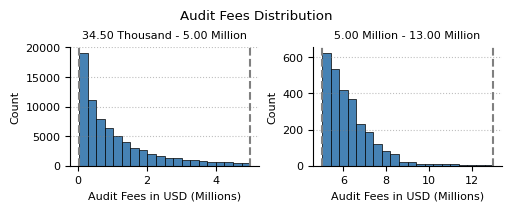

,auditFees
Samples,73616
Mean,"1,264,186.65"
Median,"731,850.00"
Std.,"1,466,846.87"
25%,"270,000.00"
75%,"1,660,293.50"
Min,"34,500.00"
Max,"13,000,000.00"
Skewness,2.14
Kurtosis,8.47


In [24]:
data = analysis_df["auditFees"].dropna()

plot_split_histograms(
    data,
    value_splits=[5_000_000],
    x_label="Audit Fees in USD",
    y_label="Count",
    title=f"Audit Fees Distribution",
    value_multiplier="auto",
)

basic_stats_table(data).T

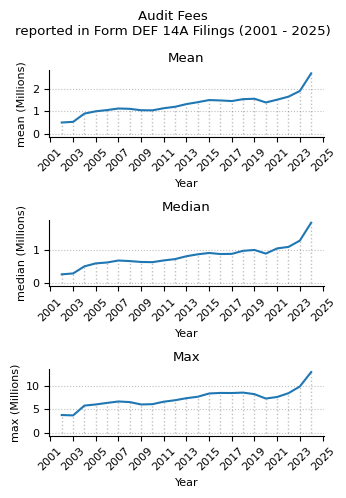

In [25]:
# Group by year and calculate stats
audit_fees = analysis_df.groupby("year")["auditFees"].agg(
    min="min", max="max", mean="mean", median="median"
)

fig, axes = plt.subplots(nrows=3, figsize=(3.5, 5))
fig.suptitle(f"Audit Fees\nreported in {form_name} Filings ({min_year} - {max_year})")
axes = axes.flatten()
for ax, key in zip(axes, ["mean", "median", "max"]):
    pretty_key = key.capitalize()
    plot_timeseries(
        ts=audit_fees,
        title=f"{pretty_key}",
        keys=[key],
        ylog_scale=False,
        yvalue_multiplier=1_000_000,
        ax=ax,
        yticks_step=2,
    )

## Audit-related fees


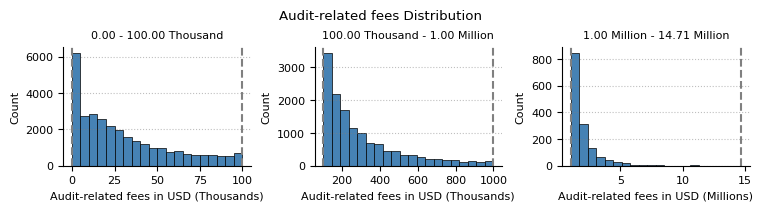

,auditRelatedFees
Samples,45441
Mean,"174,159.18"
Median,"45,000.00"
Std.,"430,556.51"
25%,"14,000.00"
75%,"155,020.00"
Min,0.00
Max,"14,714,000.00"
Skewness,8.3
Kurtosis,125.1


In [26]:
data = analysis_df["auditRelatedFees"].dropna()

plot_split_histograms(
    data,
    value_splits=[100_000, 1_000_000],
    x_label="Audit-related fees in USD",
    y_label="Count",
    title=f"Audit-related fees Distribution",
    value_multiplier="auto",
)

basic_stats_table(data).T

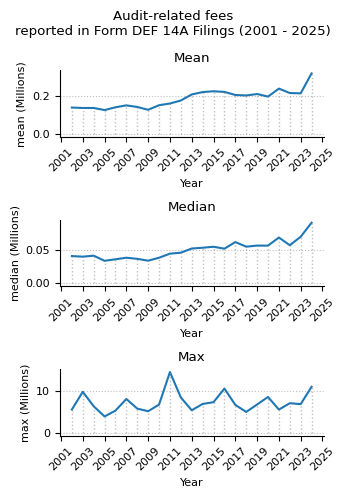

In [27]:
# Group by year and calculate stats
audit_related_fees = (
    analysis_df[analysis_df["year"].between(2000, 2026)]
    .groupby("year")["auditRelatedFees"]
    .agg(min="min", max="max", mean="mean", median="median")
)

fig, axes = plt.subplots(nrows=3, figsize=(3.5, 5))
fig.suptitle(
    f"Audit-related fees\nreported in {form_name} Filings ({min_year} - {max_year})"
)
axes = axes.flatten()
for ax, key in zip(axes, ["mean", "median", "max"]):
    pretty_key = key.capitalize()
    plot_timeseries(
        ts=audit_related_fees,
        title=f"{pretty_key}",
        keys=[key],
        ylog_scale=False,
        yvalue_multiplier=1_000_000,
        ax=ax,
        yticks_step=2,
    )

## Tax Fees


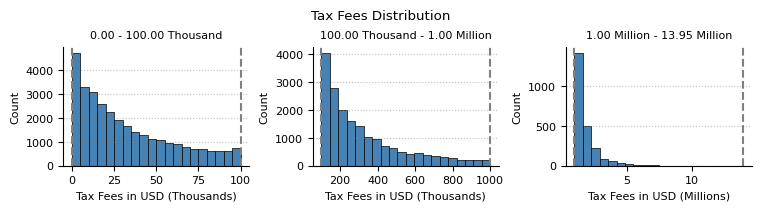

,taxFees
Samples,51969
Mean,"218,435.22"
Median,"63,000.00"
Std.,"464,899.76"
25%,"18,200.00"
75%,"215,117.00"
Min,0.00
Max,"13,952,000.00"
Skewness,6.99
Kurtosis,99.28


In [28]:
data = analysis_df["taxFees"].dropna()
data = data[data >= 0]

plot_split_histograms(
    data,
    value_splits=[100_000, 1_000_000],
    x_label="Tax Fees in USD",
    y_label="Count",
    title=f"Tax Fees Distribution",
    value_multiplier="auto",
)

basic_stats_table(data).T

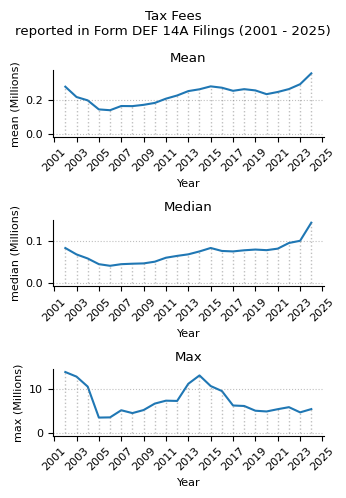

In [29]:
# Group by year and calculate stats
tax_fees = (
    analysis_df[analysis_df["year"].between(2000, 2026)]
    .groupby("year")["taxFees"]
    .agg(min="min", max="max", mean="mean", median="median")
)

fig, axes = plt.subplots(nrows=3, figsize=(3.5, 5))
fig.suptitle(f"Tax Fees\nreported in {form_name} Filings ({min_year} - {max_year})")
axes = axes.flatten()
for ax, key in zip(axes, ["mean", "median", "max"]):
    pretty_key = key.capitalize()
    plot_timeseries(
        ts=tax_fees,
        title=f"{pretty_key}",
        keys=[key],
        ylog_scale=False,
        yvalue_multiplier=1_000_000,
        ax=ax,
        yticks_step=2,
    )

## All other fees


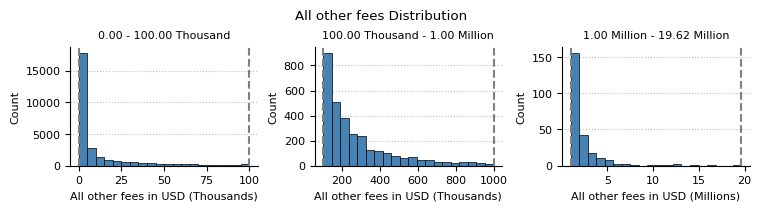

,allOtherFees
Samples,31230
Mean,"55,931.24"
Median,"3,000.00"
Std.,"316,426.37"
25%,0.00
75%,"23,402.25"
Min,0.00
Max,"19,624,000.00"
Skewness,27.79
Kurtosis,1195.41


In [30]:
data = analysis_df["allOtherFees"].dropna()
data = data[data >= 0]

plot_split_histograms(
    data,
    value_splits=[100_000, 1_000_000],
    x_label="All other fees in USD",
    y_label="Count",
    title=f"All other fees Distribution",
    value_multiplier="auto",
)

basic_stats_table(data).T

## Evolution and comparison of fee types


Fee by type reported in Form DEF 14A Filings (2002 - 2026)


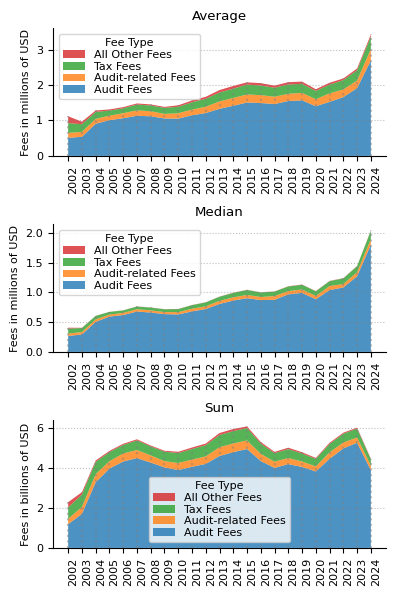

In [31]:
fix, axes = plt.subplots(3, 1, figsize=(4, 6))
fig.suptitle(f"Fee by type reported in {form_name} Filings (2002 - 2026)")


for ax, (name, method, order_of_magnitude) in zip(
    axes,
    [
        ("Average", "mean", "million"),
        ("Median", "median", "million"),
        ("Sum", "sum", "billion"),
    ],
):

    values_by_year = (
        analysis_df.groupby("year")
        .agg(
            audit_fees=("auditFees", method),
            audit_related_fees=("auditRelatedFees", method),
            tax_fees=("taxFees", method),
            all_other_fees=("allOtherFees", method),
        )
        .reset_index()
    )

    values_by_year["year"] = values_by_year["year"].astype(int)

    stacked_values = values_by_year.copy()
    multiplier = 1_000_000 if order_of_magnitude == "million" else 1_000_000_000
    for key in ["audit_fees", "audit_related_fees", "tax_fees", "all_other_fees"]:
        stacked_values[key] = stacked_values[key] / multiplier

    ax.stackplot(
        stacked_values["year"].astype(str),
        *[
            stacked_values[ft]
            for ft in ["audit_fees", "audit_related_fees", "tax_fees", "all_other_fees"]
        ],
        labels=["Audit Fees", "Audit-related Fees", "Tax Fees", "All Other Fees"],
        alpha=0.8,
    )
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        list(reversed(handles)),
        list(reversed(labels)),
        title="Fee Type",
        labelspacing=0.15,
    )

    # ax.set_title(f"{name} of fees by type reported in {form_name} Filings (2002 - 2026)")
    ax.set_title(f"{name}")
    ax.set_ylabel(f"Fees in {order_of_magnitude}s of USD")
    xticks = stacked_values["year"].astype(str)
    ax.set_xticks([i for i, x in enumerate(xticks)])

    ax.set_xticklabels(
        [label.get_text()[:4] for label in ax.get_xticklabels()], rotation=90, ha="left"
    )

    ax.grid(axis="y", linestyle=":", alpha=0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # draw vertical lines for each first month of the year, dotted, transparency 0.5,
    # with height of the y value for the respective month
    for year in stacked_values["year"]:
        ax.vlines(
            f"{year}",
            ymin=0,
            ymax=stacked_values[(stacked_values["year"] == year)]
            .drop(columns=["year"])
            .sum(axis=1),
            linestyle=":",
            alpha=0.5,
            color="grey",
        )

plt.tight_layout()
print(f"Fee by type reported in {form_name} Filings (2002 - 2026)")
plt.show()